# Run or Walk
Using the Run or Walk dataset ([read about it here](https://towardsdatascience.com/run-or-walk-detecting-user-activity-with-machine-learning-and-core-ml-part-1-9658c0dcdd90)) to detect whether a person is running or walking.

## Utilities
This is just a few methods for training using different learning rates and batch sizes, and plotting the results afterwards.

In [0]:
def train_model(model, train_tuple, loss_function, epochs, rates=[0.01, 0.001], batches=[32, 64, 128], metrics=[], validation_tuple=None, verbose=2):
  train_x, train_y = train_tuple  
  
  full_history = {
      "loss": []
  }
  if validation_tuple is not None:
    full_history["val_loss"] = []
  for metric in metrics:
    full_history[metric] = []
    if validation_tuple is not None:
      full_history[f"val_{metric}"] = []
  
  for rate in rates:
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=rate), loss=loss_function, metrics=metrics)

    for batch in batches:
      print(f"Rate: {rate}, batch: {batch}")
      history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch, validation_data=validation_tuple, verbose=verbose)
      
      for key in full_history:
        if key in history.history:
          full_history[key].extend(history.history[key])
          
          
  return full_history

def plot_history(history, validation_in_same=False):
  num_plots = len(history)
  if validation_in_same:    
    for k in history:
      if k.startswith("val_"):
        num_plots -= 1
    
  import math
  rows = math.ceil(num_plots / 2)
  cols = min(2, num_plots)
  fig, plots = plt.subplots(rows, cols, figsize=(cols * 7, rows * 4))

  if cols == 1:
    plots = np.array([plots])
  
  old_shape = plots.shape
  plots = plots.reshape(num_plots)

  i = 0
  for (k, v) in history.items():
    if k.startswith("val_"):
      continue
    
    plots[i].plot(v)
    print(k, history.keys())
    if validation_in_same:
      if f"val_{k}" in history:
        plots[i].plot(history[f"val_{k}"])
    plots[i].set_xlabel('epochs')
    plots[i].set_ylabel(k)
    plots[i].set_title(k)
    i += 1
    
  plots = plots.reshape(old_shape)
  
  plt.show()

## Data preparation

Fetching the data from Kaggle and preparing for modeling.

In [3]:
!mkdir -p .kaggle
!mkdir -p ~/.kaggle

import json
token = {"username":"andreas3","key":"d7fdda019228abf7d8adda3fe706ef9f"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
    
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

!kaggle config set -n path -v{/content}

!kaggle datasets download vmalyi/run-or-walk -p /content

!unzip run-or-walk.zip

- path is now set to: {/content}
  0% 0.00/2.26M [00:00<?, ?B/s]
100% 2.26M/2.26M [00:00<00:00, 67.7MB/s]
Archive:  run-or-walk.zip
  inflating: dataset.csv             


In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn.preprocessing
import matplotlib.pyplot as plt

We load the data and make sure that it is sorted by date and time, since we want to not use single points in time but small periods to detect the activity. It is more likely tha we can detect the activity by looking at the last e.g. 10 timesteps than just a single point in time.

We also create a validation set for use during training and a test set to see the final performance of the model

In [5]:
data = pd.read_csv("dataset.csv")
data = data.sort_values(['date','time'], ascending=True)

train_end = int(len(data)*0.8)
valid_end = int(len(data)*0.9)

train = data[0:train_end]
valid = data[train_end:valid_end]
test = data[valid_end:]

len(train), len(valid), len(test)

(70870, 8859, 8859)

In [6]:
data.head()

,date,time,username,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,2017-6-30,13:51:15:847724020,viktor,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,2017-6-30,13:51:16:246945023,viktor,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,2017-6-30,13:51:16:446233987,viktor,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,2017-6-30,13:51:16:646117985,viktor,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,2017-6-30,13:51:16:846738994,viktor,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922


Here we plot the acceleration in all three axes and compare with the labelled activity. We see that there is a big difference in acceleration between walking (0) and running (1).

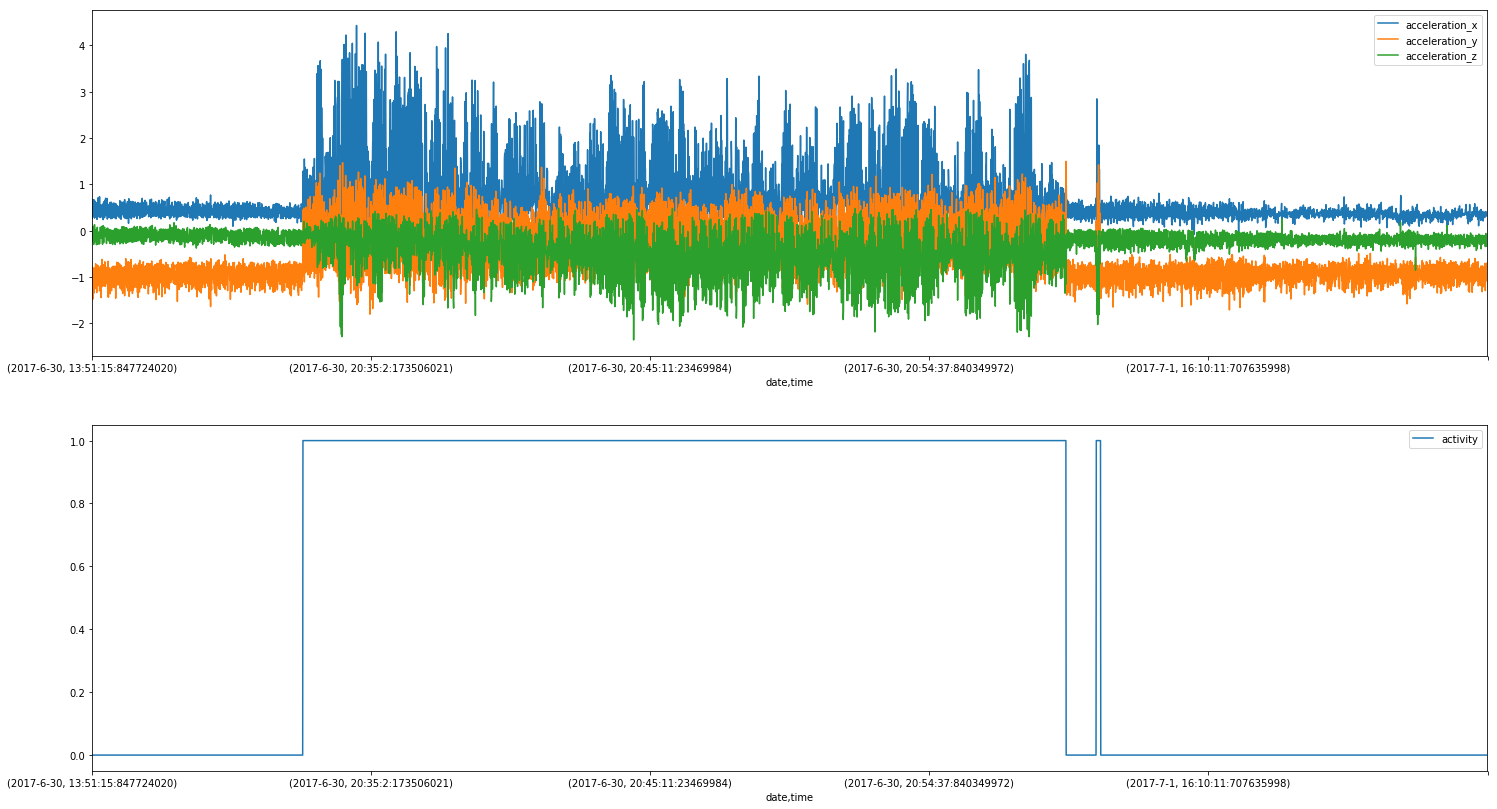

In [7]:
fig, plots = plt.subplots(2, 1, figsize=(25, 14))

data.set_index(["date", "time"]).iloc[0:5000, 3:6].plot(ax=plots[0])
data.set_index(["date", "time"]).iloc[0:5000, 2:3].plot(ax=plots[1])

We normalize all features, so they are between 0 and 1 (and drop information on user, date and time).

In [8]:
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data.iloc[:, 3:])
scaled_data = pd.DataFrame(scaled_data, columns=data.columns[3:])
scaled_data.head()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,0.0,0.0,0.512653,0.421921,0.694500,0.469822,0.469670,0.315740
1,0.0,0.0,0.549827,0.364622,0.652454,0.457280,0.468937,0.463068
2,0.0,0.0,0.528620,0.304558,0.709293,0.378310,0.474293,0.339498
3,0.0,0.0,0.516131,0.416709,0.712371,0.489049,0.441955,0.315547
4,0.0,0.0,0.532409,0.396816,0.702564,0.481827,0.495067,0.577079


We now transform the data from single points of time into small timeseries. Basically, we go from:

```
X_0, y
X_1, y
X_2, y
```

to 

```
X_0 X_1 .. X_n, y_n
X_1 X_2 .. X_n+1, y_n+1
```
where `n` is the number of steps in a timeseries. We thus use the previous `n` steps to predict the activity at timestep `n`.

In [0]:
i = 0
SAMPLE_SIZE = 12
Y_INDEX = 1

def transform(data):
  data_x = []
  data_y = []

  for i in range(0, len(data) - SAMPLE_SIZE):
    data_x.append(scaled_data.iloc[i:i+SAMPLE_SIZE, 2:5].values.reshape(-1))
    data_y.append(scaled_data.iloc[i+SAMPLE_SIZE, Y_INDEX])

  return np.array(data_x), np.array(data_y)

train_x, train_y = transform(train)
valid_x, valid_y = transform(valid)
test_x, test_y = transform(test)

We decided to use 12 timesteps and only use acceleration. There are two reasons for using only acceleration:

1. We actually get almost as good result using only acceleration as when using both acceleration and rotation.
2. We want to use the model in a small web-app, and we were only able to measure the acceleration reliably from Javascript (actually, it seems like the rotation was measured differently in the dataset than what we get from through the browser). 

In [10]:
print(f"Train: {train_x.shape}, {train_y.shape}\nValid: {valid_x.shape}, {valid_y.shape}\nTest: {test_x.shape}, {test_y.shape}")

Train: (70858, 36), (70858,)
Valid: (8847, 36), (8847,)
Test: (8847, 36), (8847,)


## Modeling
We build an extremely simple model - just a single hidden layer with 32 units and a sigmoid activation for the output.

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, input_shape=(train_x.shape[1:]), activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                1184      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = train_model(model, (train_x, train_y), "binary_crossentropy", 10, rates=[0.01, 0.001], batches=[16, 32, 64], metrics=["acc"], validation_tuple=(valid_x, valid_y), verbose=2)

Rate: 0.01, batch: 16
Train on 70858 samples, validate on 8847 samples
Epoch 1/10
 - 5s - loss: 0.0311 - acc: 0.9923 - val_loss: 0.0271 - val_acc: 0.9945
Epoch 2/10
 - 5s - loss: 0.0181 - acc: 0.9968 - val_loss: 0.0318 - val_acc: 0.9930
Epoch 3/10
 - 5s - loss: 0.0163 - acc: 0.9970 - val_loss: 0.0228 - val_acc: 0.9946
Epoch 4/10
 - 5s - loss: 0.0161 - acc: 0.9971 - val_loss: 0.0218 - val_acc: 0.9955
Epoch 5/10
 - 5s - loss: 0.0160 - acc: 0.9971 - val_loss: 0.0208 - val_acc: 0.9956
Epoch 6/10
 - 5s - loss: 0.0151 - acc: 0.9971 - val_loss: 0.0233 - val_acc: 0.9947
Epoch 7/10
 - 5s - loss: 0.0149 - acc: 0.9972 - val_loss: 0.0228 - val_acc: 0.9946
Epoch 8/10
 - 5s - loss: 0.0150 - acc: 0.9972 - val_loss: 0.0328 - val_acc: 0.9915
Epoch 9/10
 - 5s - loss: 0.0145 - acc: 0.9972 - val_loss: 0.0285 - val_acc: 0.9924
Epoch 10/10
 - 5s - loss: 0.0141 - acc: 0.9973 - val_loss: 0.0236 - val_acc: 0.9945
Rate: 0.01, batch: 32
Train on 70858 samples, validate on 8847 samples
Epoch 1/10
 - 3s - loss: 0.

loss dict_keys(['loss', 'val_loss', 'acc', 'val_acc'])
acc dict_keys(['loss', 'val_loss', 'acc', 'val_acc'])


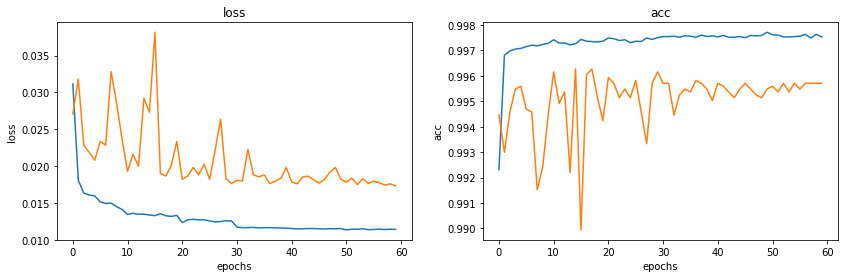

In [20]:
plot_history(history, validation_in_same=True)

We get 99,6% accuracy on the test-set:

In [21]:
model.evaluate(test_x, test_y)

8847/8847 [==============================] - 0s 24us/sample - loss: 0.0173 - acc: 0.9957


[0.0173305013312617, 0.99570477]

Finally, we just save the model, so it can be used in the web-app.

In [0]:
model.save("runorwalk.h5")